In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, BasicAer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

In [2]:
backend = BasicAer.get_backend('qasm_simulator')

In [3]:
# quantum plain addition algorithm for 1-qubit numbers    
def addition_1bit(circuit, q):
    circuit.cx(q[0], q[2])
    circuit.cx(q[1], q[2])
    circuit.ccx(q[0], q[1], q[3])
    
# n-qubit number input state
def number_state(circuit, q, a, b):
    if a == 1:
        circuit.x(q[0]) # q[0] contains the value of a
    if b == 1:
        circuit.x(q[1]) # q[1] contain the value of b

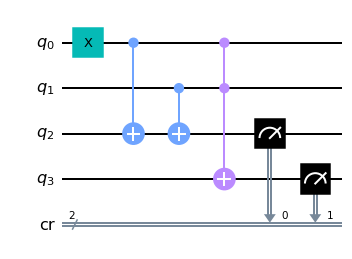

In [4]:
# we define the values (0 or 1)
b = 0
a = 1                 

# one single quantum register which contains 'a' (1 qubit) and 'b' (2 qubits)
q = QuantumRegister(4, name="q") # 4 qubits
# clasical register
c = ClassicalRegister(2, name="cr") # 2 bits

# quantum circuit involving the quantum register and the classical register
add1bit_circuit = QuantumCircuit(q ,c, name="add")

# create the state containing a and b
number_state(add1bit_circuit, q, a, b)

# addition
addition_1bit(add1bit_circuit, q)

# measurements to see the result, which has been written in b (q[2]q[3])
add1bit_circuit.measure(q[2], c[0])
add1bit_circuit.measure(q[3], c[1])

add1bit_circuit.draw()


In [5]:
# compile and execute the quantum program in the backend
result = execute(add1bit_circuit, backend, shots=1000).result()

Result(backend_name='qasm_simulator', backend_version='2.1.0', qobj_id='dae168ed-5a1a-4203-b878-d7ac4d4eb7c3', job_id='23810211-8f25-4f2f-9c94-c4f49a30e5a8', success=True, results=[ExperimentResult(shots=1000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x1': 1000}), header=QobjExperimentHeader(clbit_labels=[['cr', 0], ['cr', 1]], creg_sizes=[['cr', 2]], global_phase=0.0, memory_slots=2, metadata={}, n_qubits=4, name='add', qreg_sizes=[['q', 4]], qubit_labels=[['q', 0], ['q', 1], ['q', 2], ['q', 3]]), status=DONE, name='add', seed_simulator=1941920165, time_taken=0.002595186233520508)], status=COMPLETED, status=QobjHeader(backend_name='qasm_simulator', backend_version='2.1.0'), time_taken=0.0026121139526367188)
{'01': 1000}


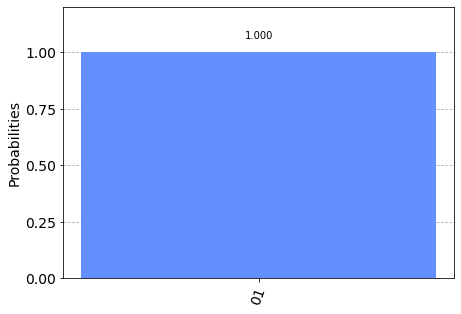

In [6]:
# show the results
print(result)
#print(result.get_data(add1bit_circuit))
counts  = result.get_counts(add1bit_circuit)
print(counts)
plot_histogram(counts)

In [7]:
print("Backend:", backend.name())
print("Highest probability outcome: {}".format(int(max(counts, key = lambda x: counts[x]).replace(" ", ""), 2)))

Backend: qasm_simulator
Highest probability outcome: 1


In [8]:
def carry(circuit, q0, q1, q2, q3):
    "carry module"
    circuit.ccx(q1, q2, q3)
    circuit.cx(q1, q2)
    circuit.ccx(q0, q2, q3)
    
def carry_inv(circuit, q0, q1, q2, q3):
    "carry module but running backwards"
    circuit.ccx(q0, q2, q3)
    circuit.cx(q1, q2)
    circuit.ccx(q1, q2, q3)
    
def summation(circuit, q0, q1, q2):
    "summation module"
    circuit.cx(q1, q2)
    circuit.cx(q0, q2)
    
# quantum plain addition algorithm for n-qubit numbers    
def addition_nbit(circuit, qa, qb, qcar, n):
    if n == 1:
        circuit.ccx(qa[0], qb[0], qb[1])
        circuit.cx(qa[0], qb[0])
    else:
        circuit.ccx(qa[0], qb[0], qcar[0])
        circuit.cx(qa[0], qb[0])
        for i in range(n-2):
            carry(circuit, qcar[i], qa[i+1], qb[i+1], qcar[i+1])
        carry(circuit, qcar[n-2], qa[n-1], qb[n-1], qb[n])
        circuit.cx(qa[n-1], qb[n-1])
        for i in range(n-1, 1, -1):
            summation(circuit, qcar[i-1], qa[i], qb[i])
            carry_inv(circuit, qcar[i-2], qa[i-1], qb[i-1], qcar[i-1])
        summation(circuit, qcar[0], qa[1], qb[1])
        circuit.cx(qa[0], qb[0])
        circuit.ccx(qa[0], qb[0], qcar[0])
        circuit.cx(qa[0], qb[0])

In [9]:
# n-qubit number input state
def number_state(circuit, q, x, n):
    # integer to binary
    x = "{0:b}".format(x)
    x = x.zfill(n)
    # creating the state
    for i in range(n):
        if int(x[n-1-i]) == 1:
            circuit.x(q[i])

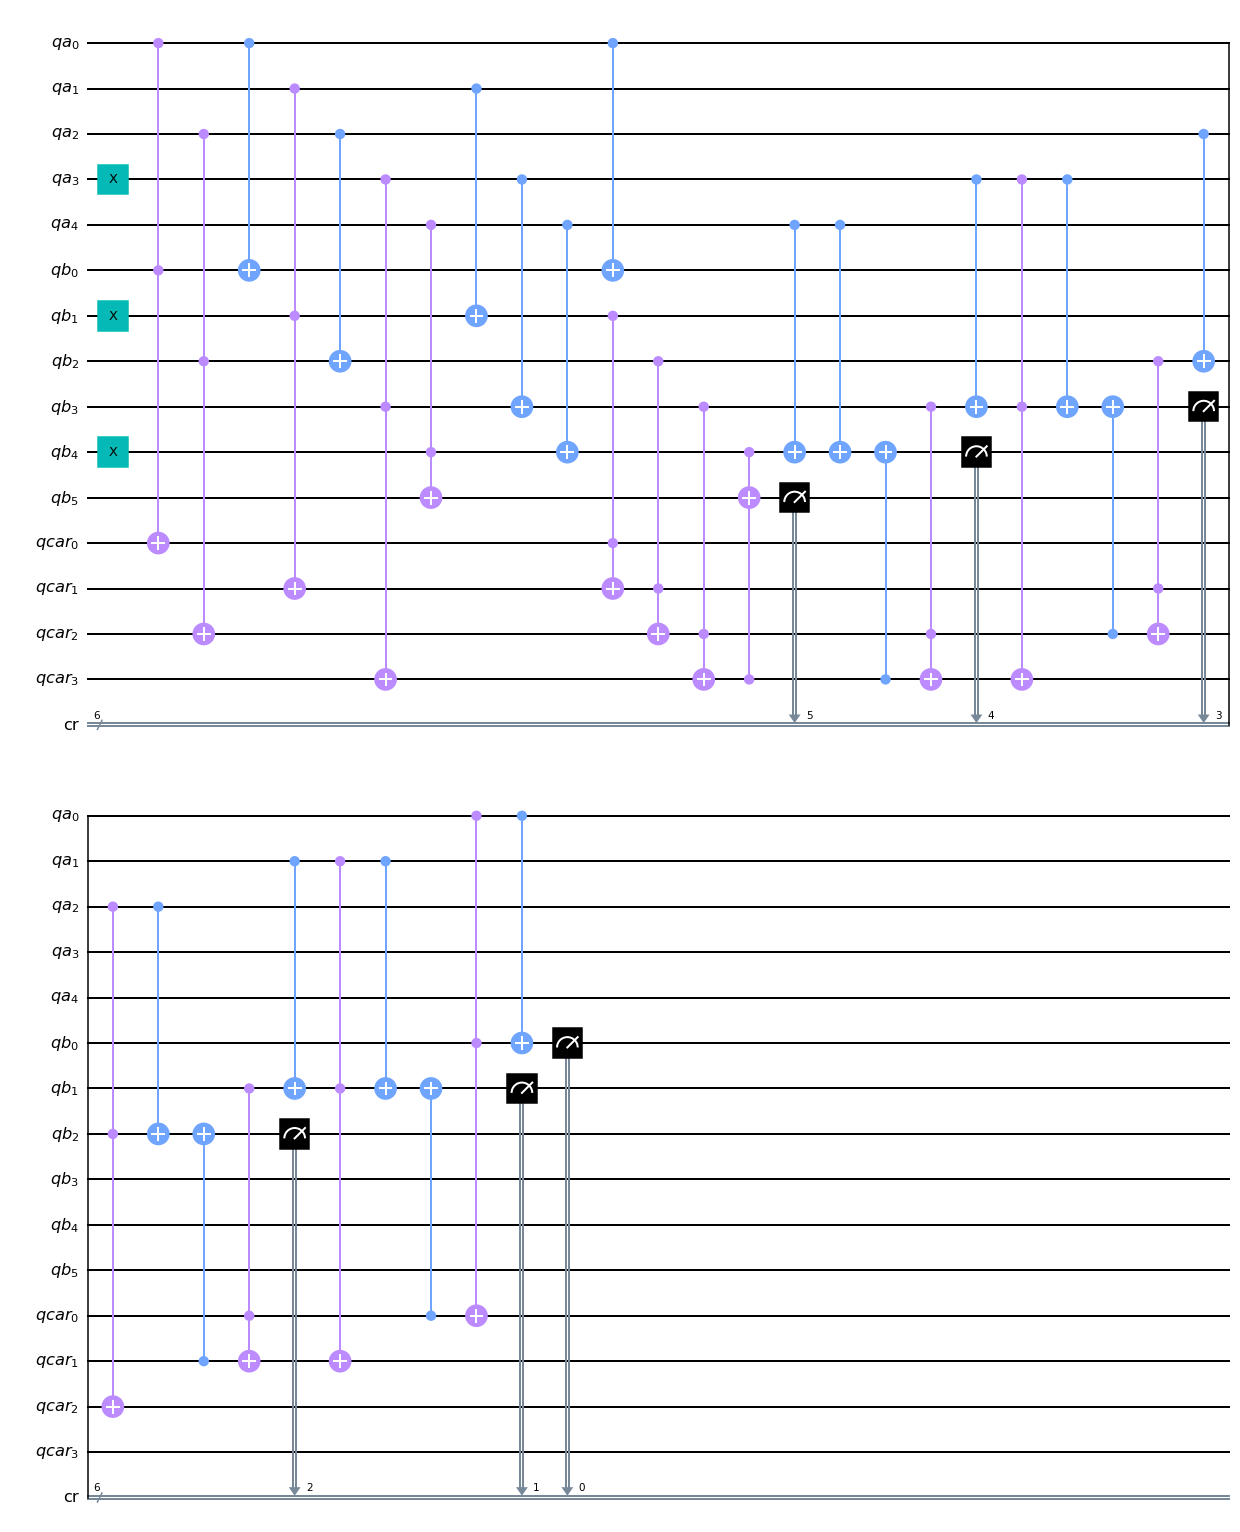

In [10]:
# we define the values
a = 8                 
b = 18

# computing the number of qubits n needed
n = len("{0:b}".format(a))
n2 = len("{0:b}".format(b))
if n2 > n:
    n = n2
    
# classical register with n+1 bits.
c = ClassicalRegister(n+1, name="cr")
# quantum registers
qa = QuantumRegister(n, name="qa") # a qubits
qb = QuantumRegister(n+1, name="qb") # b qubits
# if n = 1, no need of carry register 
if n == 1:
    qcar = 0
    # quantum circuit involving the quantum registers and the classical register
    addnbit_circuit = QuantumCircuit(qa, qb,c, name="add")
else:
    qcar = QuantumRegister(n-1, name="qcar") # carry qubits
    # quantum circuit involving the quantum registers and the classical register
    addnbit_circuit = QuantumCircuit(qa, qb, qcar,c, name="add")

# create the state containing a
number_state(addnbit_circuit, qa, a, n)
# create the state containing b
number_state(addnbit_circuit, qb, b, n)

# addition
addition_nbit(addnbit_circuit, qa, qb, qcar, n)

# measurements to see the result
for i in range(n+1):
    addnbit_circuit.measure(qb[i], c[i])

addnbit_circuit.draw()

Result(backend_name='qasm_simulator', backend_version='2.1.0', qobj_id='4aa52dca-423d-4828-b2fd-6e6bd1555d20', job_id='7229aa42-4f45-421e-850c-5cef2be8bae0', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x1a': 1024}), header=QobjExperimentHeader(clbit_labels=[['cr', 0], ['cr', 1], ['cr', 2], ['cr', 3], ['cr', 4], ['cr', 5]], creg_sizes=[['cr', 6]], global_phase=7.771561172376096e-16, memory_slots=6, metadata={}, n_qubits=15, name='add', qreg_sizes=[['qa', 5], ['qb', 6], ['qcar', 4]], qubit_labels=[['qa', 0], ['qa', 1], ['qa', 2], ['qa', 3], ['qa', 4], ['qb', 0], ['qb', 1], ['qb', 2], ['qb', 3], ['qb', 4], ['qb', 5], ['qcar', 0], ['qcar', 1], ['qcar', 2], ['qcar', 3]]), status=DONE, name='add', seed_simulator=945605479, time_taken=0.09786653518676758)], status=COMPLETED, status=QobjHeader(backend_name='qasm_simulator', backend_version='2.1.0'), time_taken=0.09788894653320312)
{'011010': 1024}


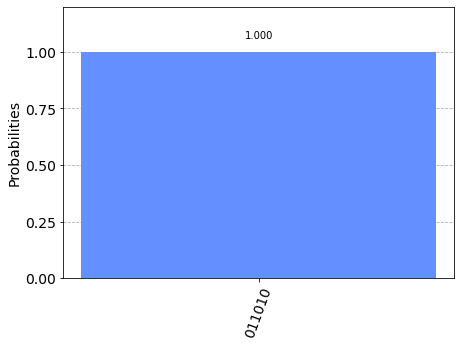

In [11]:
# compile and execute the quantum program in the backend
result = execute(addnbit_circuit, backend=backend, shots=1024).result()

# show the results.
print(result)
counts = result.get_counts(addnbit_circuit)
print(counts)
plot_histogram(counts)

In [12]:
print("Backend:", backend.name())
print("Highest probability outcome: {}".format(int(max(counts, key = lambda x: counts[x]).replace(" ", ""), 2)))

Backend: qasm_simulator
Highest probability outcome: 26
